
### T2 Data Analysis  

        Sean Keenan, PhD Physics  
        Quantum Memories Group, Heriot-Watt University, Edinburgh  
        2021  

In [95]:
import os
import spec_funcs as sf
import fit_funcs as ff
import numpy as np
import pandas as pd
import matplotlib.pyplot as mp
from scipy.signal import fftconvolve

path = r"C:\Users\sk88\Desktop\YSO_Coherence"


##### Import Data  

        Load data sets & extract time and echo data


In [ ]:
_, files = sf.dir_interogate(path)
file_paths = [os.path.join(path, x) for x in files]
data_sets = [pd.read_csv(file_path) for file_path in file_paths]
data_set = data_sets[0]
data = [data_set[x].values.tolist() for x in data_set]
mp.figure()
mp.plot(data[0], data[3])

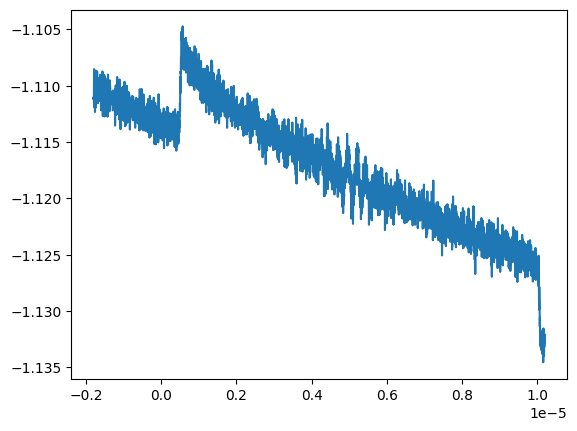

In [111]:
_, files = sf.dir_interogate(path)
file_paths = [os.path.join(path, x) for x in files]
test_sets = [pd.read_csv(file_path) for file_path in file_paths]
test = [[test_set[x].values.tolist() for x in test_set] for test_set in test_sets]

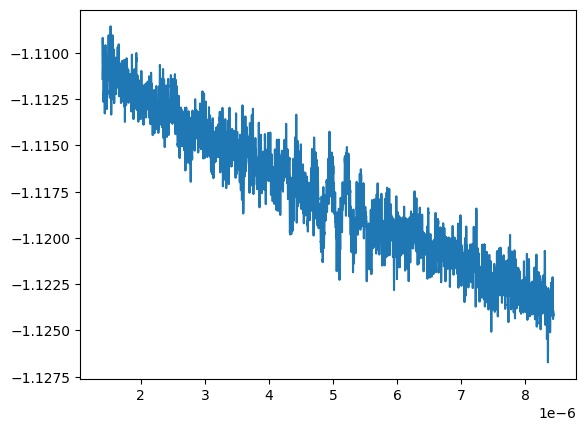

In [97]:
cut_10M_0 = data[3][8000:-4400]
cut_10M_x = data[0][8000:-4400]
mp.figure()
mp.plot(cut_10M_x, cut_10M_0)

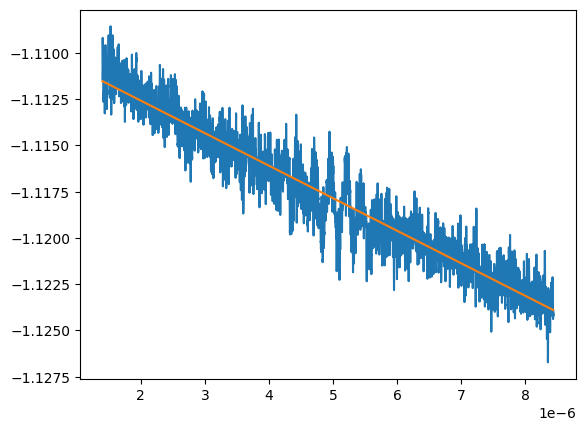

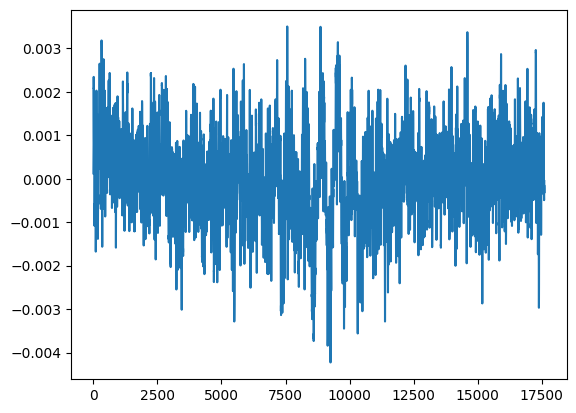

In [98]:
fit, fit_err = ff.fitstraight(cut_10M_x, cut_10M_0)
straight = ff.straight(cut_10M_x, *fit)
mp.figure()
mp.plot(cut_10M_x, cut_10M_0)
mp.plot(cut_10M_x, straight)

fixed = np.asarray(cut_10M_0) - np.asarray(straight)

mp.figure()
mp.plot(fixed)

In [99]:
T = cut_10M_x[1]-cut_10M_x[0] # time interval
sr = 1/T # sampling rate
N = np.size(cut_10M_x)
M = 101
freq = sf.fftfreq(N, T)

print(T, sr, N)

4.0000000000003005e-10 2499999999.999812 17600


In [100]:
low_pass = 50E6
trans_band = 25E5
b = trans_band/sr
lfc = low_pass/sr
lM = int(np.ceil((4/b)))
lpf = ff.low_pass(lM, lfc)
nlp = len(lpf) // 2
ma = ff.moving_av(M)
nma = len(ma)//2
filtered = fftconvolve(lpf, fixed)
smoothed = fftconvolve(ma, fixed)

fftd = np.sqrt(np.abs(sf.fft(filtered)))
ffts = np.sqrt(np.abs(sf.fft(smoothed)))

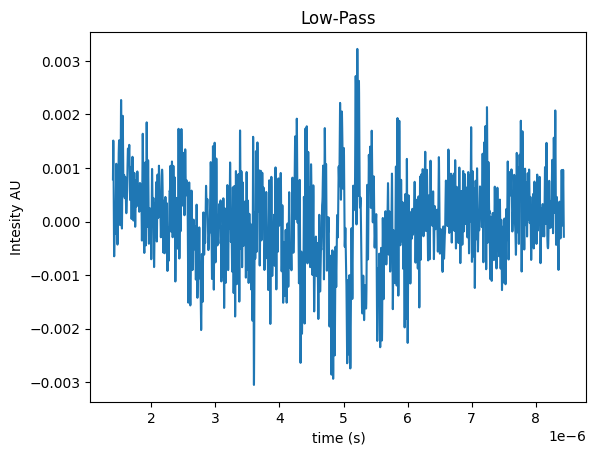

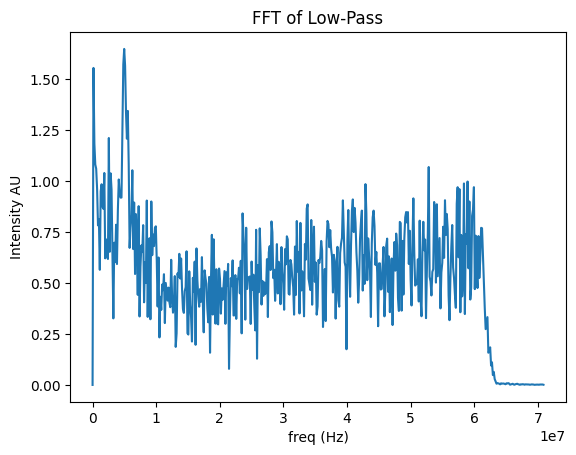

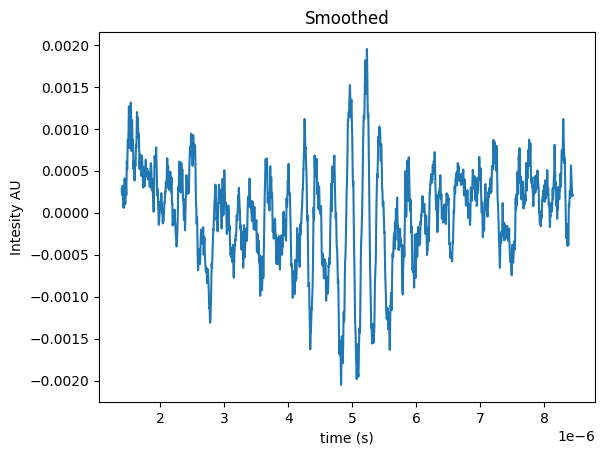

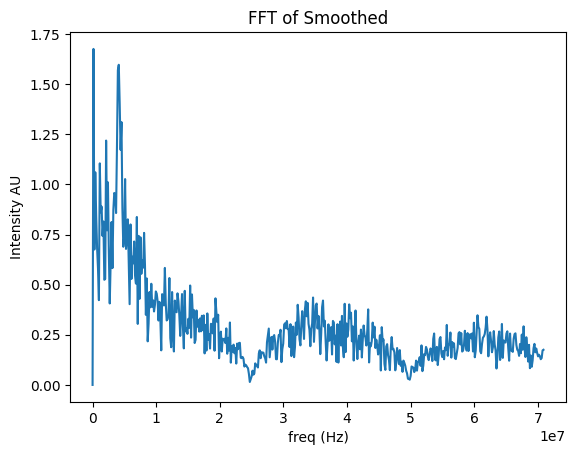

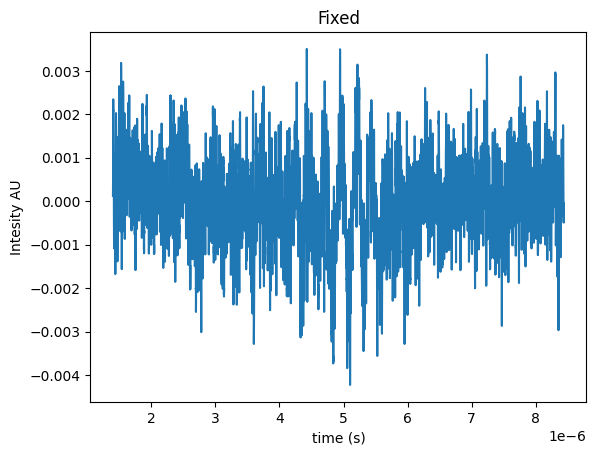

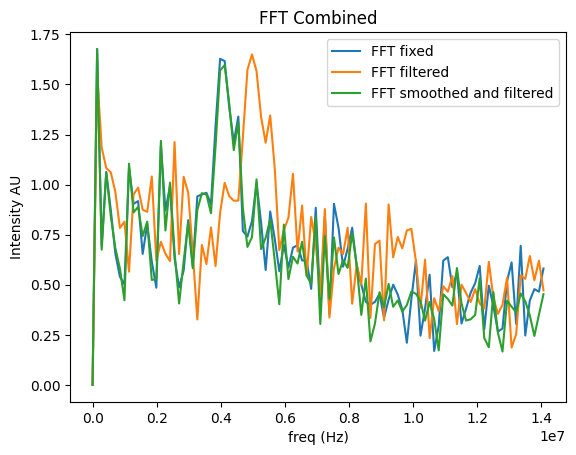

In [101]:
# filtered data
mp.figure()
mp.title('Low-Pass')
mp.xlabel('time (s)')
mp.ylabel('Intesity AU')
mp.plot(cut_10M_x, filtered[nlp:-nlp])

mp.figure()
mp.title('FFT of Low-Pass')
mp.xlabel('freq (Hz)')
mp.ylabel('Intensity AU')
mp.plot(freq[0:500], fftd[0:500])

# smoothed data
mp.figure()
mp.title('Smoothed')
mp.xlabel('time (s)')
mp.ylabel('Intesity AU')
mp.plot(cut_10M_x, smoothed[nma:-nma])

mp.figure()
mp.title('FFT of Smoothed')
mp.xlabel('freq (Hz)')
mp.ylabel('Intensity AU')
mp.plot(freq[0:500], ffts[0:500])

mp.figure()
mp.title('Fixed')
mp.xlabel('time (s)')
mp.ylabel('Intesity AU')
mp.plot(cut_10M_x, fixed)

mp.figure()
mp.title('FFT Combined')
mp.xlabel('freq (Hz)')
mp.ylabel('Intensity AU')
mp.plot(freq[0:100], np.sqrt(np.abs(sf.fft(fixed)))[0:100], label='FFT fixed')
mp.plot(freq[0:100], fftd[0:100], label='FFT filtered')
mp.plot(freq[0:100], ffts[0:100], label='FFT smoothed and filtered')
mp.legend(loc='best')